# Setup

In [1]:
import scipy
import math
import numpy as np
from diagonalize import State, delta, neg_1_pow, Interaction, Molecule
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
int_wigner_arr = np.load("wigner3j_integer_N=10.npy")
halfint_wigner_arr = np.load("wigner3j_halfint_N=3.5.npy")

def T_int(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

def T_half_int(n3, n1, m3, m1, n2, m2, N = 7/2):
    n3 = n3 - 0.5 # 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3 (max is (N - 0.5))
    n1 = n1 - 0.5 # 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3 (max is (N - 0.5))
    
    n2 = n2 # 0, 1, 2 (max is 2)
    m2 = m2 + 2 # -2, -1, 0, 1, 2 -> 0, 1, 2, 3, 4 (max is 4)
    
    m3 = m3 + N # -7/2, -5/2, -3/2, -1/2, 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3, 4, 5, 6, 7 (max is N*2)
    m1 = m1 + N # -7/2, -5/2, -3/2, -1/2, 1/2, 3/2, 5/2, 7/2 -> 0, 1, 2, 3, 4, 5, 6, 7 (max is N*2)
    
    # max: (4)    (4)+(2*5)    (4+2*5)+(15*N*2)    (4+2*5+15*N*2)+(15+30*N)*N*2   (4+2*5+15*N*2)+(15+30*N)*N*2 + (15+60*N+60*N*N)*(N-0.5)
    return int(m2     + 5 * n2         + 15 * m1               + (15+30*N)*m3  + (15+60*N+60*N*N)*n1     + (60*N*N*N + 90*N*N + 45*N + 7.5)*n3)
    
def wigner_3j(n1, n2, n3, m1, m2, m3):
    if n1 == int(n1) and n2 == int(n2) and n3 == int(n3):
        return int_wigner_arr[T_int(n3,n1,m3,m1,n2,m2)]
    return halfint_wigner_arr[T_half_int(n3,n1,m3,m1,n2,m2)]
    

In [3]:
h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def centrifugal(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return -n*(n+1)**2
    return 0

def quad_Na(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not delta(m2, m2_):
        return 0
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = wigner_3j(i1, 2, i1, -m1, -p, m1_)
        sum_term += neg_1_pow(p) * wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = wigner_3j(i1, 2, i1, -i1, 0, i1)
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(-mn+i1-m1)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def quad_Cs(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not delta(m1, m1_):
        return 0
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = wigner_3j(i2, 2, i2, -m2, -p, m2_)
        sum_term += neg_1_pow(p) * wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = wigner_3j(i2, 2, i2, -i2, 0, i2)
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(-mn+i2-m2)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def spin_rot_Na(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m2, m2_)):
        return 0
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, mn, p, -mn_)
        wigp2 = wigner_3j(i1, 1, i1, m1, -p, -m1_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
       
    if sum_term == 0:
        return 0
        
    other = neg_1_pow(n+mn_+i1+m1_) * math.sqrt(n * (n + 1) * (2*n + 1) * i1 * (i1 + 1) * (2*i1 + 1))
    if other == 0:
        return 0 

    return sum_term * other

def spin_rot_Cs(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m1, m1_)):
        return 0
    
    other = neg_1_pow(n+mn_+i2+m2_) * math.sqrt(n * (n + 1) * (2*n + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0 
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, mn, p, -mn_)
        wigp2 = wigner_3j(i2, 1, i2, m2, -p, -m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(mn, mn_)):
        return 0
    
    other = neg_1_pow(i1+m1_+i2+m2_) * math.sqrt(i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(i1, 1, i1, m1, p, -m1_)
        wigp2 = wigner_3j(i2, 1, i2, m2, -p, -m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin_dip(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    sqrtpart = -math.sqrt(30 * i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1) * (2*n + 1) * (2*n_ + 1))
    
    negpart = neg_1_pow(i1 + i1 - m1 - m2 - mn)
    
    wig0 = wigner_3j(n, 2, n_, 0, 0, 0)
    
    sum = 0
    
    for p in range(-1,2):
        wig1 = wigner_3j(i2, 1, i2, -m2, -p, m2)
        
        for p1 in range(-1,2):
            for p2 in range(-1,2):
                
                wig2 = wigner_3j(n, 1, n_, -mn, p1, mn_)
                wig3 = wigner_3j(i1, 1, i1, -m1, p2, m1_)
                wig4 = wigner_3j(1, 2, 1, p1, p2, -p)
        sum += wig1 * wig2 * wig3 * wig4
        
    if sum == 0:
        return 0
    
    return sqrtpart * negpart * wig0 * sum

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    #print(state1,state2, other)
    
    return wig1 * wig2 * other

    

# Molecule Initialization

In [4]:
from scipy.constants import physical_constants
from scipy.constants import c
from scipy.constants import epsilon_0

int_rotational = Interaction(Na23Cs133["Brot"], rotational)
int_centrifugal = Interaction(Na23Cs133["Drot"], centrifugal)
int_quad_na = Interaction(Na23Cs133["Q1"], quad_Na)
int_quad_cs = Interaction(Na23Cs133["Q2"], quad_Cs)

const_nuc_spin_spin_dip = Na23Cs133["g1"] * Na23Cs133["g2"] * physical_constants["nuclear magneton"][0]**2 / (4 * math.pi * epsilon_0 * c * c)
int_nuc_spin_spin_dip = Interaction(const_nuc_spin_spin_dip, nuc_spin_spin_dip)
int_nuc_spin_spin = Interaction(Na23Cs133["C4"], nuc_spin_spin)
int_spin_rot_Na = Interaction(Na23Cs133["C1"], spin_rot_Na)
int_spin_rot_Cs = Interaction(Na23Cs133["C2"], spin_rot_Cs)
int_stark = Interaction(Na23Cs133["d0"], stark)

In [5]:
NaCs = Molecule(range(11), 0, 0)

NaCs.add_interaction(int_rotational)
#NaCs.add_interaction(int_centrifugal)
#NaCs.add_interaction(int_quad_na)
#NaCs.add_interaction(int_quad_cs)
#NaCs.add_interaction(int_nuc_spin_spin)
#NaCs.add_interaction(int_nuc_spin_spin_dip)
#NaCs.add_interaction(int_spin_rot_Na)
#NaCs.add_interaction(int_spin_rot_Cs)
NaCs.add_changing_interaction(int_stark)

H has dim 121


In [6]:
NaCs.find_H_zero()
NaCs.find_H_prime()

array([[[ 0.00000000e+00,  0.00000000e+00, -9.03215514e-30, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-9.03215514e-30,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])

# Building Dip-Dip matrix over all states

First, we begin by selecting two electric field strengths to represent the electric fields of each qubit. $E_1$ will correspond to $10 \ [kV/cm]$, while $E_2$ will correspond to $6.78 \ [kV/cm]$.

In [7]:
E_range = np.linspace(0, 10, int(60)) * 1e5
eigenvalues_and_eigenvectors_E_1 = NaCs.compute_eigenval_over_range([E_range[-1:]])
eigenvalues_and_eigenvectors_E_2 = NaCs.compute_eigenval_over_range([E_range[-20:-19]])
print("eigenvalues_and_eigenvectors_E_1 corresponds to E =",np.round(E_range[-1:][0]/1e5,2),'[kV/cm]')
print("eigenvalues_and_eigenvectors_E_2 corresponds to E =",np.round(E_range[-20:-19][0]/1e5,2),'[kV/cm]')
# not actually taking the first element; eigenvalues_and_eigenvectors_E_* is an array of tuples
eigenvalues_1, eigenvectors_1 = eigenvalues_and_eigenvectors_E_1[0]
eigenvalues_2, eigenvectors_2 = eigenvalues_and_eigenvectors_E_2[0]
basis = NaCs.states

eigenvalues_and_eigenvectors_E_1 corresponds to E = 10.0 [kV/cm]
eigenvalues_and_eigenvectors_E_2 corresponds to E = 6.78 [kV/cm]


Now, let's define the dipole dipole computation between two eigenvectors. It is simply a product of the two series representing each state. Note that we use the stark function, as it is just defined as the inner product $\bra{i}\cos(\theta)\ket{j}$.

In [8]:
def dipole_dipole_matrix_elem(evec1, evec2, basis):
    if (len(evec1) != len(evec2) or len(evec1) != len(basis)):
        raise('ArithmeticError')
    else:
        value = 0
        for i, a in enumerate(evec1):
            for j, b in enumerate(evec2):
                value += a * b * stark(basis[i], basis[j])
        return value

# Data analysis on the Dip-Dip matrix

Let's compute a matrix of all the possible transitions for this given system. Finding the maximal values in dipole coupling matrix $1$, only up to some maximum. Same for dipole coupling matrix $2$.

In [9]:
dim = len(basis)
dip_dip_matrix_1 = np.zeros((dim,dim))
for i in tqdm(range(dim)):
    for j in range(dim):
        dip_dip_matrix_1[i][j] = dipole_dipole_matrix_elem(eigenvectors_1[i], eigenvectors_1[j], basis)
dim = len(basis)
dip_dip_matrix_2 = np.zeros((dim,dim))
for i in tqdm(range(dim)):
    for j in range(dim):
        dip_dip_matrix_2[i][j] = dipole_dipole_matrix_elem(eigenvectors_2[i], eigenvectors_2[j], basis)

top10trans_1 = [[0, 0, 0] for _ in range(10)]
nmax = 3
for i, row in enumerate(dip_dip_matrix_1):
    for j, elem in enumerate(row):
        if basis[i].n > nmax or basis[j].n > nmax:
            continue
        if abs(elem) > abs(top10trans_1[0][0]):
            top10trans_1[0][0] = elem
            top10trans_1[0][1] = i
            top10trans_1[0][2] = j
            top10trans_1 = sorted(top10trans_1, key=lambda x: abs(x[0]))
for elem in np.around(top10trans_1,2):
    print(elem, "corresponding to states:\n", int(elem[1]), ': ', basis[int(elem[1])], "\n", int(elem[2]), ': ', basis[int(elem[2])])
    
top10trans_2 = [[0, 0, 0] for _ in range(10)]
nmax = 3

for i, row in enumerate(dip_dip_matrix_2):
    for j, elem in enumerate(row):
        if basis[i].n > nmax or basis[j].n > nmax:
            continue
        if abs(elem) > abs(top10trans_2[0][0]):
            top10trans_2[0][0] = elem
            top10trans_2[0][1] = i
            top10trans_2[0][2] = j
            top10trans_2 = sorted(top10trans_2, key=lambda x: abs(x[0]))
for elem in np.around(top10trans_2,2):
    print(elem, "corresponding to states:\n", int(elem[1]), ': ', basis[int(elem[1])], "\n", int(elem[2]), ': ', basis[int(elem[2])])

100%|██████████| 121/121 [01:47<00:00,  1.13it/s]

[ 0.28 13.   14.  ] corresponding to states:
 13 :  n: 3, mn: 1, m1: 0, m2: 0 
 14 :  n: 3, mn: 2, m1: 0, m2: 0
[-0.29  1.    8.  ] corresponding to states:
 1 :  n: 1, mn: -1, m1: 0, m2: 0 
 8 :  n: 2, mn: 2, m1: 0, m2: 0
[-0.29  8.    1.  ] corresponding to states:
 8 :  n: 2, mn: 2, m1: 0, m2: 0 
 1 :  n: 1, mn: -1, m1: 0, m2: 0
[-0.29  3.    2.  ] corresponding to states:
 3 :  n: 1, mn: 1, m1: 0, m2: 0 
 2 :  n: 1, mn: 0, m1: 0, m2: 0
[-0.29  2.    3.  ] corresponding to states:
 2 :  n: 1, mn: 0, m1: 0, m2: 0 
 3 :  n: 1, mn: 1, m1: 0, m2: 0
[-0.3  7.   7. ] corresponding to states:
 7 :  n: 2, mn: 1, m1: 0, m2: 0 
 7 :  n: 2, mn: 1, m1: 0, m2: 0
[0.35 9.   9.  ] corresponding to states:
 9 :  n: 3, mn: -3, m1: 0, m2: 0 
 9 :  n: 3, mn: -3, m1: 0, m2: 0
[ 0.38 10.    8.  ] corresponding to states:
 10 :  n: 3, mn: -2, m1: 0, m2: 0 
 8 :  n: 2, mn: 2, m1: 0, m2: 0
[ 0.38  8.   10.  ] corresponding to states:
 8 :  n: 2, mn: 2, m1: 0, m2: 0 
 10 :  n: 3, mn: -2, m1: 0, m2: 0
[0.4 3

Let's arbitrarily chose states $\ket{0}$ and $\ket{1}$ for our qubit to be just eigenstates $0$ and $1$ of each molecule.

Text(0.5, 1.0, 'Spectrum of each molecule')

<Figure size 640x480 with 0 Axes>

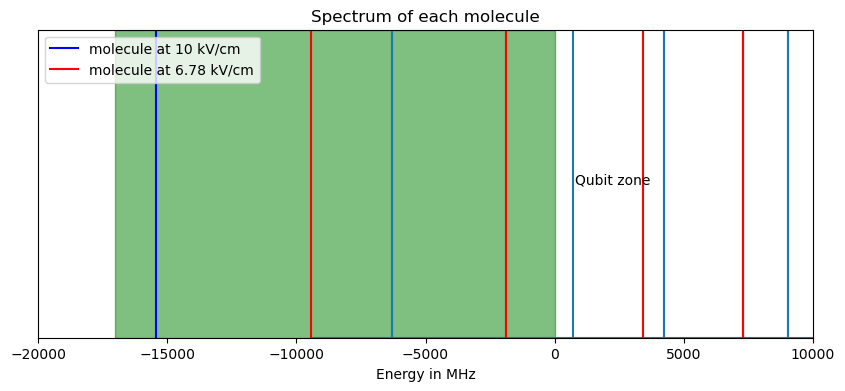

In [10]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,4))

energy_range = np.arange(eigenvalues_2[0], eigenvalues_2[-1], (eigenvalues_2[-1]-eigenvalues_2[0])/len(eigenvalues_2))
plt.plot(energy_range*1e-6/h, np.zeros(len(energy_range)))

start = True
for val1 in eigenvalues_1:
    if start:
        ax.axvline(val1*1e-6/h, c='b', label = 'molecule at 10 kV/cm')
        start = False
    else:
        ax.axvline(val1*1e-6/h)
    
start = True
for val2 in eigenvalues_2:
    if start:
        ax.axvline(val2*1e-6/h, c='r', label = 'molecule at 6.78 kV/cm')
        start = False
    else:
        ax.axvline(val2*1e-6/h, c='r')


ax.axvspan(-17000, 0, color='green', alpha=0.5)
ax.text(800, 0.5, 'Qubit zone')

ax.get_yaxis().set_visible(False)
ax.set_xlabel('Energy in MHz')
ax.set_ylim(0,1)
ax.set_xlim(-20000,10000)
ax.legend()

ax.set_title('Spectrum of each molecule')

We need to find matrix of dip-dip int wrt:

$\ket{00} \ket{01} \ket{10} \ket{11}$

In [11]:
eigenstateind1 = 0
eigenstateind2 = 1


dip_int_q1 = [dipole_dipole_matrix_elem(eigenvectors_1[eigenstateind1], eigenvectors_1[eigenstateind1], basis), dipole_dipole_matrix_elem(eigenvectors_1[eigenstateind1], eigenvectors_1[eigenstateind2], basis), dipole_dipole_matrix_elem(eigenvectors_1[eigenstateind2], eigenvectors_1[eigenstateind2], basis)]

dip_int_q2 = [dipole_dipole_matrix_elem(eigenvectors_2[eigenstateind1], eigenvectors_2[eigenstateind1], basis), dipole_dipole_matrix_elem(eigenvectors_2[eigenstateind1], eigenvectors_2[eigenstateind2], basis), dipole_dipole_matrix_elem(eigenvectors_2[eigenstateind2], eigenvectors_2[eigenstateind2], basis)]

dip_matrix = np.array([
    [dip_int_q1[0]*dip_int_q2[0], dip_int_q1[0]*dip_int_q2[1], dip_int_q1[1]*dip_int_q2[0], dip_int_q1[1]*dip_int_q2[1]],
    [dip_int_q1[0]*dip_int_q2[1], dip_int_q1[0]*dip_int_q2[2], dip_int_q1[1]*dip_int_q2[1], dip_int_q1[1]*dip_int_q2[2]],
    [dip_int_q1[1]*dip_int_q2[0], dip_int_q1[1]*dip_int_q2[1], dip_int_q1[2]*dip_int_q2[0], dip_int_q1[2]*dip_int_q2[1]],
    [dip_int_q1[1]*dip_int_q2[1], dip_int_q1[1]*dip_int_q2[2], dip_int_q1[2]*dip_int_q2[1], dip_int_q1[2]*dip_int_q2[2]],
                      ])

# Examining Time Dependence of the 4-state System
Namely of: $\ket{00} \ket{01} \ket{10} \ket{11}$

In [12]:
print("Dipole Dipole coupling elements for individual molecule states:\n", np.around(dip_int_q1, 2), "\n", np.around(dip_int_q2, 2))
print("Dipole Dipole coupling matrix between qubit states:\n", np.around(dip_matrix,2))

Dipole Dipole coupling elements for individual molecule states:
 [-0.   -0.25 -0.09] 
 [ 0.    0.14 -0.08]
Dipole Dipole coupling matrix between qubit states:
 [[-0.   -0.   -0.   -0.03]
 [-0.    0.   -0.03  0.02]
 [-0.   -0.03 -0.   -0.01]
 [-0.03  0.02 -0.01  0.01]]


Ok; we have 4 states:

$\ket{00} \ket{01} \ket{10} \ket{11}$

We need to find $H_0$, $V_{dd}$, and also $H_{ij}(t) = \bra{i} \cos(\theta_{mol})\ket{j}$ in MHz.

In [13]:
Na23Cs133["d0"]**2

2.4473947928378257e-58

In [14]:
bohr**3

1.481847114721628e-31

In [16]:
# note that the 1e-6/h factor is for the conversion
# from Joules to MHz

V_0 = np.array([
    [eigenvalues_1[0] + eigenvalues_2[0], 0, 0, 0],
    [0, eigenvalues_1[0] + eigenvalues_2[1], 0, 0],
    [0, 0, eigenvalues_1[1] + eigenvalues_2[0], 0],
    [0, 0, 0, eigenvalues_1[1] + eigenvalues_2[1]]
    ])

r_12 = 1*bohr 
V_dd = (Na23Cs133["d0"]**2) * (1/r_12**3) * dip_matrix

# |00> |01> |10> |11>
V_t1 = np.array([
    [dip_int_q1[0], 0, dip_int_q1[1], 0],
    [0, dip_int_q1[0], 0, dip_int_q1[1]],
    [dip_int_q1[1], 0, dip_int_q1[2], 0],
    [0, dip_int_q1[1], 0, dip_int_q1[2]],
                      ])

# |00> |01> |10> |11>
V_t2 = np.array([
    [dip_int_q1[0], dip_int_q1[1], 0, 0],
    [dip_int_q1[1], dip_int_q1[2], 0, 0],
    [0, 0, dip_int_q1[0], dip_int_q1[1]],
    [0, 0, dip_int_q1[1], dip_int_q1[2]],
                      ])

# our laser electric field strength, in V/m
Laser_E = 1e4
V_laser_1 = Laser_E * Na23Cs133["d0"] * V_t1
V_laser_2 = Laser_E * Na23Cs133["d0"] * V_t2

# lets start with a laser coupling the |00> |01> states
# it has frequency equal to w_0 / hbar

Laser_w_12 = (eigenvalues_2[1] - eigenvalues_2[0])*2*math.pi/h
Laser_w_13 = (eigenvalues_1[1] - eigenvalues_1[0])*2*math.pi/h
Laser_w_14 = (eigenvalues_1[1] + eigenvalues_2[1] - eigenvalues_1[0] + eigenvalues_2[0])*2*math.pi/h
def laser_osc(t):
    return np.cos(Laser_w_13*t) # This really seems unnecessary: + np.sin(Laser_w*t)*1j
#V_laser = np.vectorize(V_laser)


In [27]:
eigenstateind1 = 0
eigenstateind2 = 3


dip_int_q1 = [dipole_dipole_matrix_elem(eigenvectors_1[eigenstateind1], eigenvectors_1[eigenstateind1], basis), dipole_dipole_matrix_elem(eigenvectors_1[eigenstateind1], eigenvectors_1[eigenstateind2], basis), dipole_dipole_matrix_elem(eigenvectors_1[eigenstateind2], eigenvectors_1[eigenstateind2], basis)]

dip_int_q2 = [dipole_dipole_matrix_elem(eigenvectors_2[eigenstateind1], eigenvectors_2[eigenstateind1], basis), dipole_dipole_matrix_elem(eigenvectors_2[eigenstateind1], eigenvectors_2[eigenstateind2], basis), dipole_dipole_matrix_elem(eigenvectors_2[eigenstateind2], eigenvectors_2[eigenstateind2], basis)]

dip_matrix_test = np.array([
    [dip_int_q1[0]*dip_int_q2[0], dip_int_q1[0]*dip_int_q2[1], dip_int_q1[1]*dip_int_q2[0], dip_int_q1[1]*dip_int_q2[1]],
    [dip_int_q1[0]*dip_int_q2[1], dip_int_q1[0]*dip_int_q2[2], dip_int_q1[1]*dip_int_q2[1], dip_int_q1[1]*dip_int_q2[2]],
    [dip_int_q1[1]*dip_int_q2[0], dip_int_q1[1]*dip_int_q2[1], dip_int_q1[2]*dip_int_q2[0], dip_int_q1[2]*dip_int_q2[1]],
    [dip_int_q1[1]*dip_int_q2[1], dip_int_q1[1]*dip_int_q2[2], dip_int_q1[2]*dip_int_q2[1], dip_int_q1[2]*dip_int_q2[2]],
                      ])


r_12 = 1000*bohr 
V_dd_test = (Na23Cs133["d0"]**2) * (1/r_12**3) * dip_matrix_test / (4 * math.pi * eps0)
np.around(np.linalg.eigh(V_0 + V_dd_test)[1],10)

array([[-9.99999999e-01,  4.00000000e-09, -1.37000000e-08,
         4.49827000e-05],
       [-2.20000000e-09, -9.99999885e-01, -4.76988600e-04,
         3.98704000e-05],
       [ 6.20000000e-09,  4.76982000e-04, -9.99999872e-01,
        -1.66307400e-04],
       [ 4.49827000e-05,  3.99497000e-05, -1.66288400e-04,
         9.99999984e-01]])

Let's now use scipy runge-kutta to see how the system evolves, starting in the $\ket{00}$ state, with laser couping to the $\ket{10}$ state. 

In [18]:
from scipy.integrate import solve_ivp
import pylab

In [19]:
def norm(x):
    sum = 0
    for elem in x:
        sum += abs(elem)*abs(elem)
    return sum

Symplectic method. Renormalize. Higher order runge kutta, accurate but unstable.

In [20]:
def solve_ivp_renormed(func, t_span, y0, t_eval, method):
    sol = np.array([])
    y0 = y0
    sol = np.append(sol, y0)
    for i, elem in enumerate(t_eval[1:]):
        #print(i)
        
        # solving over a single timestep using python solver
        pysol = solve_ivp(func, t_eval[i:i+2], y0, method = method)
        
        #extracting and renormalizing solution from python solver solution
        y0 = pysol.y.T[-1]
        y0 = y0 / math.sqrt(norm(y0))
        
        # adding this solution point to our solution
        sol = np.vstack((sol, y0))
        
        #renormalization
        
    return sol.T

In [28]:
def rhs (t, psi):
    system = V_0 + (V_laser_1+V_laser_2)*laser_osc(t)
    dpsi_dt = np.dot(system, psi) * -1j * 2*math.pi / h
    return dpsi_dt

# We start in the |00> state
psi_0 = [1+0j,0+0j,0+0j,0+0j]

t0 = 0
tfinal = 100e-9
ts = np.linspace(t0, tfinal, 10000)

sol = solve_ivp_renormed(rhs, [t0, tfinal], psi_0, t_eval=ts, method = 'DOP853')

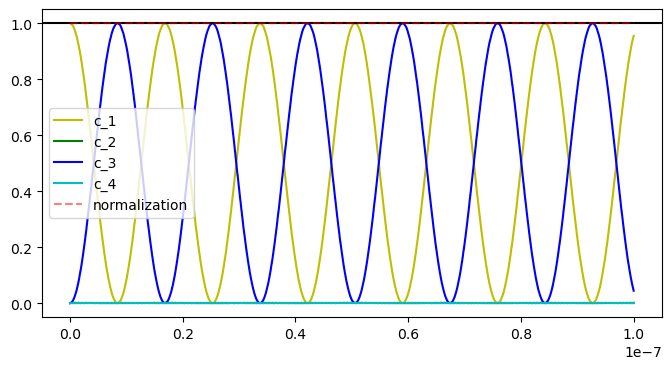

In [29]:
c_1 = sol[0]
c_2 = sol[1]
c_3 = sol[2]
c_4 = sol[3]

c_1_square = np.abs(c_1)**2
c_2_square = np.abs(c_2)**2
c_3_square = np.abs(c_3)**2
c_4_square = np.abs(c_4)**2


fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ts, c_1_square, 'y', label='c_1')
ax.plot(ts, c_2_square, 'g', label='c_2')
ax.plot(ts, c_3_square, 'b', label='c_3')
ax.plot(ts, c_4_square, 'c', label='c_4')
ax.axhline(1, c='k')
ax.plot(ts, c_1_square+c_2_square+c_3_square+c_4_square, 'r', linestyle='--', label = 'normalization', alpha = 0.5)
ax.legend()